In [1]:
%pylab inline
import matplotlib.pyplot as pl
from astropy.io import fits
import numpy as np

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [12]:
decade_dir='/project2/chihway/data/decade/'
File_list = ['DES1213-3457', 'DES1224-3749', 'DES1225-4206', 'DES1318-3623', 'DES1319-3457']

In [13]:
i=0
infile = fits.open(decade_dir+File_list[i]+'_cat.fits')
print(infile[1].header.keys)

<bound method Header.keys of XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                 1224 / width of table in bytes                        
NAXIS2  =                76984 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                  158 / number of fields in each row                   
TTYPE1  = 'COADD_OBJECT_ID'    / label for field   1                            
TFORM1  = 'K       '           / data format of field: 8-byte INTEGER           
TTYPE2  = 'RA      '           / label for field   2                            
TFORM2  = 'D       '           / data format of field: 8-byte DOUBLE            

In [14]:
full_data = infile[1].data
mask_SEflag = (full_data['FLAGS_G']<=3)*(full_data['FLAGS_R']<=3)*(full_data['FLAGS_I']<=3)*(full_data['FLAGS_Z']<=3)
mask_IMAflag = (full_data['IMAFLAGS_ISO_G']==0)*(full_data['IMAFLAGS_ISO_R']==0)*(full_data['IMAFLAGS_ISO_I']==0)*(full_data['IMAFLAGS_ISO_Z']==0)
extend_coadd = np.array(((full_data['WAVG_SPREAD_MODEL_I']+3*full_data['WAVG_SPREADERR_MODEL_I'])>0.005))*1 + np.array((full_data['WAVG_SPREAD_MODEL_I']+full_data['WAVG_SPREADERR_MODEL_I'])>0.003) *1 + np.array((full_data['WAVG_SPREAD_MODEL_I']-full_data['WAVG_SPREADERR_MODEL_I'])>0.002)*1
mask_extend = (extend_coadd>=2)
SNR_R = full_data['FLUX_AUTO_R']/full_data['FLUXERR_AUTO_R']
mask_snr = (SNR_R>5)
size_R = full_data['FLUX_RADIUS_R']*0.236
mask_size = (size_R>0.5)


In [15]:
area = 0.73*0.73*60*60
print('original', len(infile[1].data), len(infile[1].data)/area)
print('SE flags', len(infile[1].data[mask_SEflag]), len(infile[1].data[mask_SEflag])/area)
print('IMA_ISO flags', len(infile[1].data[mask_SEflag*mask_IMAflag]),len(infile[1].data[mask_SEflag*mask_IMAflag])/area)
print('extend_class flags', len(infile[1].data[mask_SEflag*mask_IMAflag*mask_extend]), len(infile[1].data[mask_SEflag*mask_IMAflag*mask_extend])/area)
print('SNR cut', len(infile[1].data[mask_SEflag*mask_IMAflag*mask_extend*mask_snr]), len(infile[1].data[mask_SEflag*mask_IMAflag*mask_extend*mask_snr])/area)
print('size cut', len(infile[1].data[mask_SEflag*mask_IMAflag*mask_extend*mask_snr*mask_size]), len(infile[1].data[mask_SEflag*mask_IMAflag*mask_extend*mask_snr*mask_size])/area)





original 76984 40.128437688955614
SE flags 75954 39.591543128792146
IMA_ISO flags 75765 39.493025583286425
extend_class flags 35615 18.564562874001794
SNR cut 34148 17.79987906840975
size cut 31403 16.369029002731388


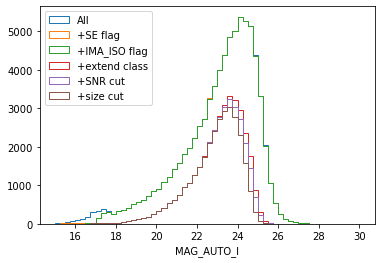

In [85]:
pl.hist(full_data['MAG_AUTO_I'], range=(15,30), bins=60, histtype='step', label='All')
pl.hist(full_data['MAG_AUTO_I'][mask_SEflag], range=(15,30), bins=60, histtype='step', label='+SE flag')
pl.hist(full_data['MAG_AUTO_I'][mask_SEflag*mask_IMAflag], range=(15,30), bins=60, histtype='step', label='+IMA_ISO flag')
pl.hist(full_data['MAG_AUTO_I'][mask_SEflag*mask_IMAflag*mask_extend], range=(15,30), bins=60, histtype='step', label='+extend class')
pl.hist(full_data['MAG_AUTO_I'][mask_SEflag*mask_IMAflag*mask_extend*mask_snr], range=(15,30), bins=60, histtype='step', label='+SNR cut')
pl.hist(full_data['MAG_AUTO_I'][mask_SEflag*mask_IMAflag*mask_extend*mask_snr*mask_size], range=(15,30), bins=60, histtype='step', label='+size cut')
pl.xlabel('MAG_AUTO_I')
pl.legend(loc=2)



In [86]:
# save coadd IDs
ids = full_data['COADD_OBJECT_ID'][mask_SEflag*mask_IMAflag*mask_extend]
np.savez('IDS_'+File_list[i]+'.npz', ids=ids)

Text(0, 0.5, 'WAVG_SPREAD_MODEL_I')

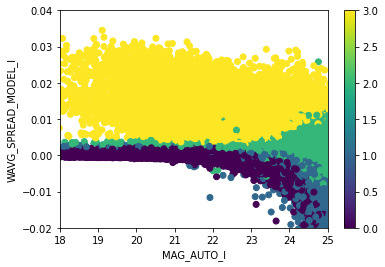

In [87]:
pl.scatter(full_data['MAG_AUTO_I'], full_data['WAVG_SPREAD_MODEL_I'], c=extend_coadd)
pl.xlim(18,25)
pl.ylim(-0.02,0.04)
pl.colorbar()
pl.xlabel('MAG_AUTO_I')
pl.ylabel('WAVG_SPREAD_MODEL_I')

Text(0.5, 1.0, 'DES1213-3457')

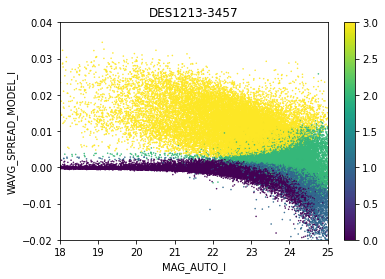

In [88]:
pl.scatter(full_data['MAG_AUTO_I'][mask_SEflag*mask_IMAflag], full_data['WAVG_SPREAD_MODEL_I'][mask_SEflag*mask_IMAflag], c=extend_coadd[mask_SEflag*mask_IMAflag],s=0.3)
pl.xlim(18,25)
pl.ylim(-0.02,0.04)
pl.colorbar()
pl.xlabel('MAG_AUTO_I')
pl.ylabel('WAVG_SPREAD_MODEL_I')
pl.title(File_list[i])


In [89]:
MM = mask_SEflag*mask_IMAflag*mask_extend
ids = full_data['COADD_OBJECT_ID'][MM]
ra = full_data['RA'][MM]
dec = full_data['DEC'][MM]
g_auto = full_data['MAG_AUTO_G'][MM]
g_autoerr = full_data['MAGERR_AUTO_G'][MM]
r_auto = full_data['MAG_AUTO_R'][MM]
r_autoerr = full_data['MAGERR_AUTO_R'][MM]
i_auto = full_data['MAG_AUTO_I'][MM]
i_autoerr = full_data['MAGERR_AUTO_I'][MM]
z_auto = full_data['MAG_AUTO_Z'][MM]
z_autoerr = full_data['MAGERR_AUTO_Z'][MM]

c0 = fits.Column(name='COADD_OBJECT_ID', format='K', array=ids)
c1 = fits.Column(name='RA', format='E', array=ra)
c2 = fits.Column(name='DEC', format='E', array=dec)
c3 = fits.Column(name='MAG_AUTO_G', format='E', array=g_auto)
c4 = fits.Column(name='MAGERR_AUTO_G', format='E', array=g_autoerr)
c5 = fits.Column(name='MAG_AUTO_R', format='E', array=r_auto)
c6 = fits.Column(name='MAGERR_AUTO_R', format='E', array=r_autoerr)
c7 = fits.Column(name='MAG_AUTO_I', format='E', array=i_auto)
c8 = fits.Column(name='MAGERR_AUTO_I', format='E', array=i_autoerr)
c9 = fits.Column(name='MAG_AUTO_Z', format='E', array=z_auto)
c10 = fits.Column(name='MAGERR_AUTO_Z', format='E', array=z_autoerr)

CC = [c1,c2,c3,c4,c5,c6,c7,c8,c9,c10]

hdu = fits.BinTableHDU.from_columns(CC, nrows=len(ra))
hdu.writeto('PZ_INPUT_'+File_list[i]+'.fits', clobber=True)






In [90]:
print(i_auto)

[24.82718277 24.98865509 22.62329102 ... 23.1074295  23.16698456
 22.32978439]


select COADD_OBJECT_ID, RA, DEC, MAG_AUTO_G, MAG_AUTO_R, MAG_AUTO_I, MAG_AUTO_Z, MAGERR_AUTO_G, MAGERR_AUTO_R, MAGERR_AUTO_I, MAGERR_AUTO_Z, TILENAME  from SHEAR_TEST_COADD_OBJECT_SUMMARY where FLAGS_G<=3 and FLAGS_R<=3 and FLAGS_I<=3 and FLAGS_Z<=3 and IMAFLAGS_ISO_G=0 and IMAFLAGS_ISO_R=0 and IMAFLAGS_ISO_I=0 and IMAFLAGS_ISO_Z=0 and 
NOT (
((WAVG_SPREAD_MODEL_I+3*WAVG_SPREADERR_MODEL_I<=0.005) and (WAVG_SPREAD_MODEL_I+WAVG_SPREADERR_MODEL_I<=0.003) and (WAVG_SPREAD_MODEL_I-WAVG_SPREADERR_MODEL_I<=0.002)) 
or 
((WAVG_SPREAD_MODEL_I+3*WAVG_SPREADERR_MODEL_I>0.005) and (WAVG_SPREAD_MODEL_I+WAVG_SPREADERR_MODEL_I<=0.003) and (WAVG_SPREAD_MODEL_I-WAVG_SPREADERR_MODEL_I<=0.002)) 
or 
((WAVG_SPREAD_MODEL_I+3*WAVG_SPREADERR_MODEL_I<=0.005) and (WAVG_SPREAD_MODEL_I+WAVG_SPREADERR_MODEL_I>0.003) and (WAVG_SPREAD_MODEL_I-WAVG_SPREADERR_MODEL_I<=0.002)) 
or 
((WAVG_SPREAD_MODEL_I+3*WAVG_SPREADERR_MODEL_I<=0.005) and (WAVG_SPREAD_MODEL_I+WAVG_SPREADERR_MODEL_I<=0.003) and (WAVG_SPREAD_MODEL_I-WAVG_SPREADERR_MODEL_I>0.002))) ;

select COADD_OBJECT_ID, RA, DEC, NEPOCHS_G, NEPOCHS_R, NEPOCHS_I, NEPOCHS_Z, MAG_AUTO_G, MAG_AUTO_R, MAG_AUTO_I, MAG_AUTO_Z, MAGERR_AUTO_G, MAGERR_AUTO_R, MAGERR_AUTO_I, MAGERR_AUTO_Z, TILENAME  from SHEAR_TEST_COADD_OBJECT_SUMMARY where FLAGS_G<=3 and FLAGS_R<=3 and FLAGS_I<=3 and FLAGS_Z<=3 and IMAFLAGS_ISO_G=0 and IMAFLAGS_ISO_R=0 and IMAFLAGS_ISO_I=0 and IMAFLAGS_ISO_Z=0 and NOT (((WAVG_SPREAD_MODEL_I+3*WAVG_SPREADERR_MODEL_I<=0.005) and (WAVG_SPREAD_MODEL_I+WAVG_SPREADERR_MODEL_I<=0.003) and (WAVG_SPREAD_MODEL_I-WAVG_SPREADERR_MODEL_I<=0.002)) or  ((WAVG_SPREAD_MODEL_I+3*WAVG_SPREADERR_MODEL_I>0.005) and (WAVG_SPREAD_MODEL_I+WAVG_SPREADERR_MODEL_I<=0.003) and (WAVG_SPREAD_MODEL_I-WAVG_SPREADERR_MODEL_I<=0.002)) or ((WAVG_SPREAD_MODEL_I+3*WAVG_SPREADERR_MODEL_I<=0.005) and (WAVG_SPREAD_MODEL_I+WAVG_SPREADERR_MODEL_I>0.003) and (WAVG_SPREAD_MODEL_I-WAVG_SPREADERR_MODEL_I<=0.002)) or ((WAVG_SPREAD_MODEL_I+3*WAVG_SPREADERR_MODEL_I<=0.005) and (WAVG_SPREAD_MODEL_I+WAVG_SPREADERR_MODEL_I<=0.003) and (WAVG_SPREAD_MODEL_I-WAVG_SPREADERR_MODEL_I>0.002)) ) ; > PZ_INPUT2.fits

In [2]:
PZ_all = fits.open('/project2/chihway/data/decade/PZ_INPUT2.fits')

In [3]:
ids = np.arange(len(PZ_all[1].data))
np.random.shuffle(ids)

DAT = PZ_all[1].data

In [ ]:
pl.scatter(DAT['RA'][ids[:10000]], DAT['DEC'][ids[:10000]], marker='.',s=1)

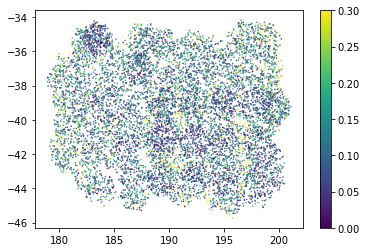

In [52]:
pl.scatter(DAT['RA'][ids[:10000]], DAT['DEC'][ids[:10000]], marker='.',s=1, c=DAT['MAGERR_AUTO_I'][ids[:10000]])
pl.clim(0,0.3)
pl.colorbar()


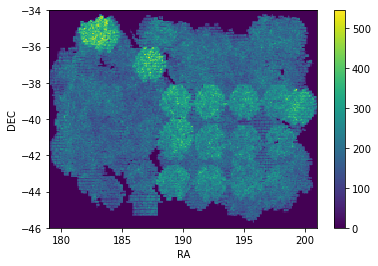

In [53]:
pl.hist2d(DAT['RA'], DAT['DEC'], range=((179, 201), (-46,-34)), bins=(200,200))
pl.xlabel('RA')
pl.ylabel('DEC')
pl.colorbar()

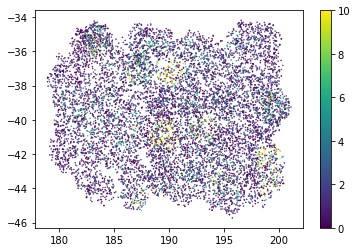

In [54]:
pl.scatter(DAT['RA'][ids[:10000]], DAT['DEC'][ids[:10000]], marker='.',s=1, c=DAT['NEPOCHS_G'][ids[:10000]])
pl.clim(0,10)
pl.colorbar()

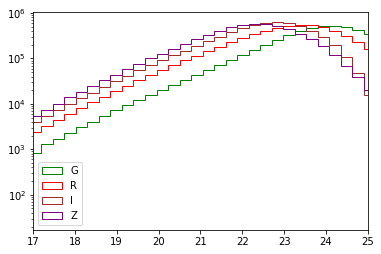

In [7]:
pl.hist(DAT['MAG_AUTO_G'], range=(15,26), bins=40, label='G', histtype='step', color='g')
pl.hist(DAT['MAG_AUTO_R'], range=(15,26), bins=40, label='R', histtype='step', color='r')
pl.hist(DAT['MAG_AUTO_I'], range=(15,26), bins=40, label='I', histtype='step', color='brown')
pl.hist(DAT['MAG_AUTO_Z'], range=(15,26), bins=40, label='Z', histtype='step', color='purple')
pl.yscale('log')
pl.xlim(17,25)
pl.legend(loc=3)

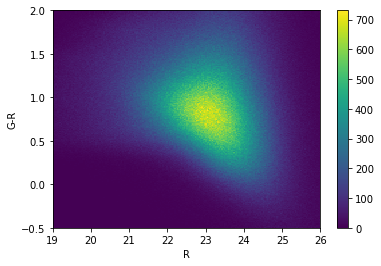

In [61]:
pl.hist2d(DAT['MAG_AUTO_R'], DAT['MAG_AUTO_G']-DAT['MAG_AUTO_R'], range=((19, 26), (-0.5,2)), bins=(200,200))
pl.xlabel('R')
pl.ylabel('G-R')
pl.colorbar()

(array([  1516.,   2233.,   3371.,   5376.,  10035.,  16967.,  32462.,
         64283., 115256., 171790., 216862., 247806., 265426., 262882.,
        239921., 210616., 182734., 158003., 131188., 110165.,  91911.,
         70931.,  51406.,  36631.,  27205.,  20818.,  16180.,  12655.,
         10414.,   8511.,   6926.,   5765.,   4958.,   4135.,   3553.,
          3044.,   2672.,   2234.,   1997.,   1733.]),
 array([-0.5   , -0.3875, -0.275 , -0.1625, -0.05  ,  0.0625,  0.175 ,
         0.2875,  0.4   ,  0.5125,  0.625 ,  0.7375,  0.85  ,  0.9625,
         1.075 ,  1.1875,  1.3   ,  1.4125,  1.525 ,  1.6375,  1.75  ,
         1.8625,  1.975 ,  2.0875,  2.2   ,  2.3125,  2.425 ,  2.5375,
         2.65  ,  2.7625,  2.875 ,  2.9875,  3.1   ,  3.2125,  3.325 ,
         3.4375,  3.55  ,  3.6625,  3.775 ,  3.8875,  4.    ]),
 <BarContainer object of 40 artists>)

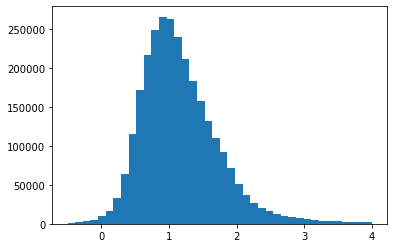

In [60]:
pl.hist(DAT['MAG_AUTO_G'][DAT['MAG_AUTO_I']<22.5]-DAT['MAG_AUTO_R'][DAT['MAG_AUTO_I']<22.5], range=(-0.5,4), bins=40)

In [3]:
### read DES Y1

In [8]:
y1_gold = fits.open('/project2/chihway/data/des_y1_catalogs/mcal-y1a1-combined-riz-unblind-v4-matched.fits')

In [9]:
len(y1_gold[1].data)

136930995

In [10]:
y1_gold[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  614 / width of table in bytes                        
NAXIS2  =            136930995 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   80 / number of fields in each row                   
TTYPE1  = 'coadd_objects_id'   / label for field   1                            
TFORM1  = 'K       '           / data format of field: 8-byte INTEGER           
TTYPE2  = 'flags   '           / label for field   2                            
TFORM2  = 'J       '           / data format of field: 4-byte INTEGER           
TTYPE3  = 'mask_frac'       